In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import Polygon, LineString, Point
from shapely.ops import unary_union
import networkx as nx

In [2]:
ContShape = gpd.read_file("../data/Continents/ref-coastline-2016-60m.shp/COAS_RG_60M_2016_4326.shp/COAS_RG_60M_2016_4326.shp")
Continent_geometry = unary_union(ContShape.geometry)


<Axes: >

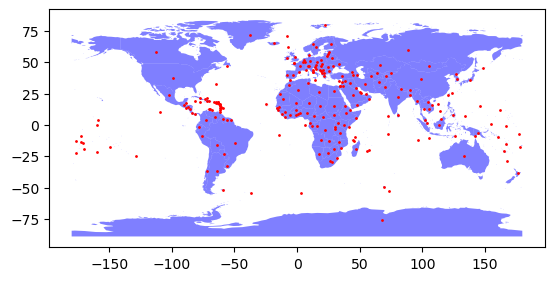

In [4]:
eezshape = gpd.read_file("../data/EEZ shapefile/EEZ_land_v2_201410.shp")
eezshape["continental_geometry"] = eezshape.geometry.intersection(Continent_geometry)
eezshape["EEZ_geometry"] = eezshape.geometry
eezshape["marine_geometry"] = eezshape.geometry.difference(eezshape.continental_geometry)
eezshape.drop(columns="geometry", axis=1, inplace=True)
eezshape.set_geometry("continental_geometry", inplace=True)

fig, ax = plt.subplots()
eezshape.plot(ax=ax, color="blue", alpha=0.5)
eezshape.geometry.representative_point().plot(
    color="red",
    markersize=1,
    ax=ax
)

In [5]:
# create a dictionary of the representative points

rep_points = eezshape.geometry.representative_point()
rep_points = rep_points.apply(lambda p: [p.x, p.y] if p else (np.nan, np.nan))
rep_points_pos = dict(zip(eezshape.Country, rep_points))
rep_points_pos

/home/gorka/.conda/envs/EEZ/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


{'Conflict zone Japan/Russia': [148.72713274436092, 45.448499999999996],
 'Conflict zone Japan/South Korea': (nan, nan),
 'Joint regime Japan/Korea': (nan, nan),
 'Conflict zone China/Japan/Taiwan': [123.50160885167463, 25.799999999999997],
 'Spratly Islands': [114.27580171130953, 11.1025],
 'Joint regime Colombia/Jamaica': (nan, nan),
 'Joint regime Nigeria/Sao Tome and Principe': (nan, nan),
 'Joint development area Australia/East Timor': (nan, nan),
 'Protected zone Australia/Papua New Guinea': [142.2138426364982,
  -9.19447640718668],
 'Hungary': [19.13579204013518, 47.172704665000055],
 'Tajikistan': [70.9491261603008, 38.87246810950006],
 'Aruba': [-69.97302782555283, 12.511],
 'Afghanistan': [65.20079089983865, 33.93967700500005],
 'Angola': [18.829397763308258, -12.043613459999968],
 'Anguilla': [-63.051501515151514, 18.2075],
 'Albania': [20.033738353932875, 41.12797765900004],
 'Andorra': [1.5815373040147094, 42.55322709100005],
 'Netherlands Antilles': [-62.90966465088527, 1

In [21]:
def long_edges(g, pos, threshold=180):
    long_edges = []
    for u, v in g.edges():
        left = min(pos[u][0], pos[v][0])
        right = max(pos[u][0], pos[v][0])
        if right - left > threshold:
            long_edges.append((u, v))
            print("remove_edges", u, v, right - left)
    return long_edges

Taxa: Cetaceans
Delay: 1
Delay: 5
Taxa: Fishes
Delay: 1
remove_edges Tonga New Zealand 352.7709472811747
Delay: 5
remove_edges Fiji Tonga 354.1621697271514
remove_edges Tonga New Zealand 352.7709472811747
Taxa: Seals
Delay: 1
Delay: 5
Taxa: Turtles
Delay: 1
remove_edges Tonga Fiji 354.1621697271514
remove_edges Marshall Is. United States Minor Outlying Islands 322.2957572795713
remove_edges United States Minor Outlying Islands Marshall Is. 322.2957572795713
Delay: 5
remove_edges American Samoa Fiji 348.7186503078607
remove_edges Tonga Fiji 354.1621697271514
remove_edges Marshall Is. United States Minor Outlying Islands 322.2957572795713


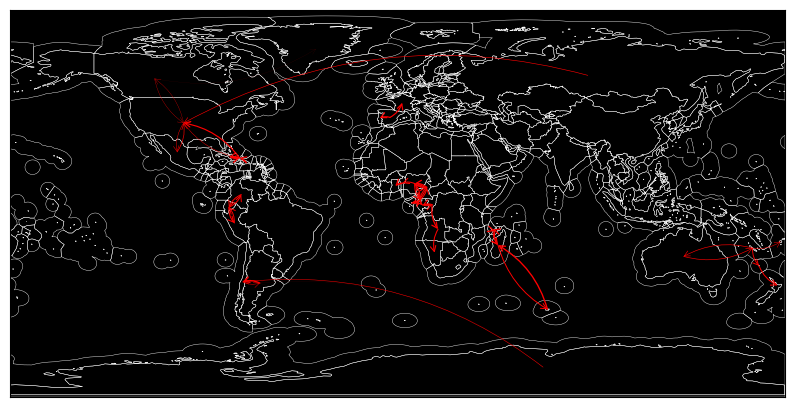

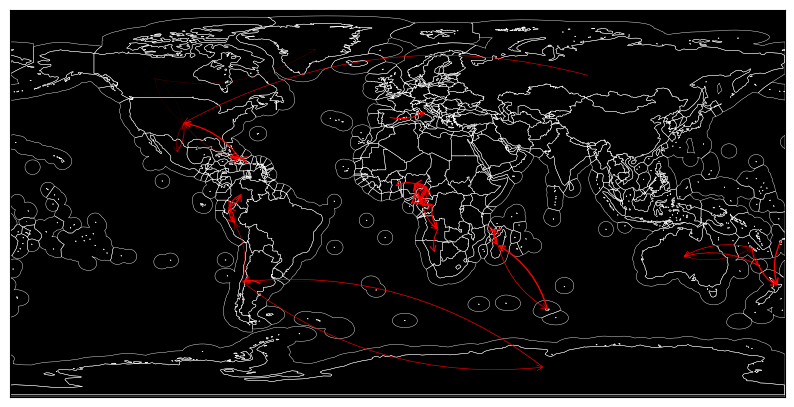

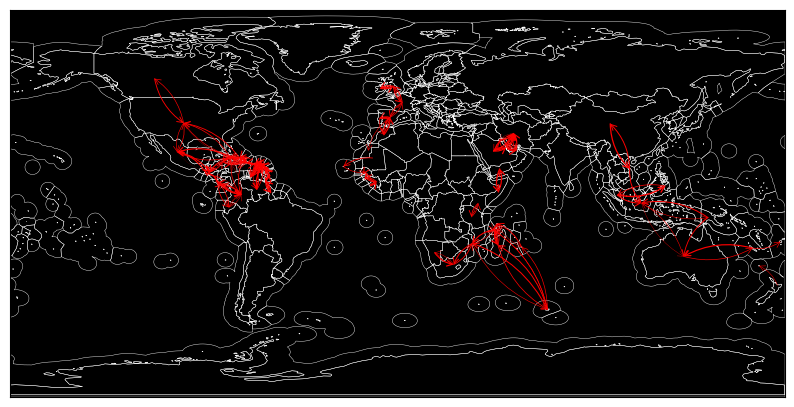

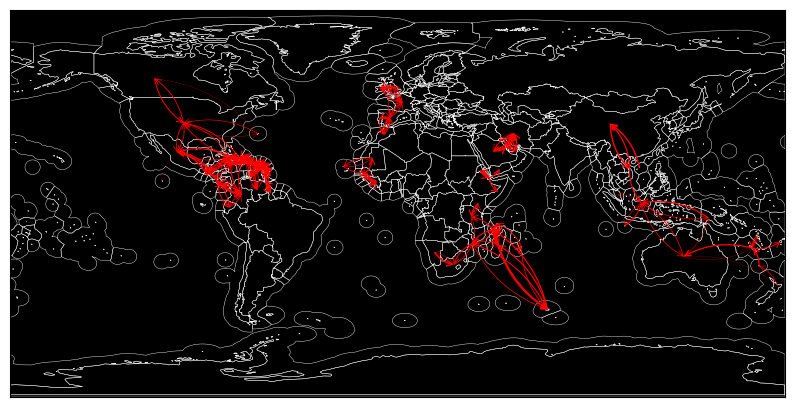

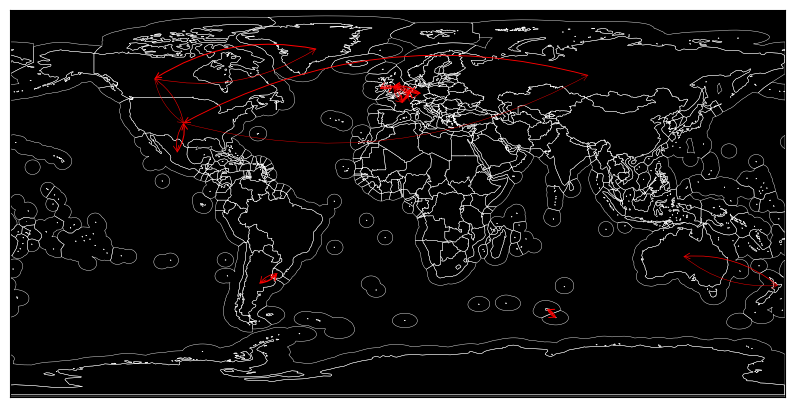

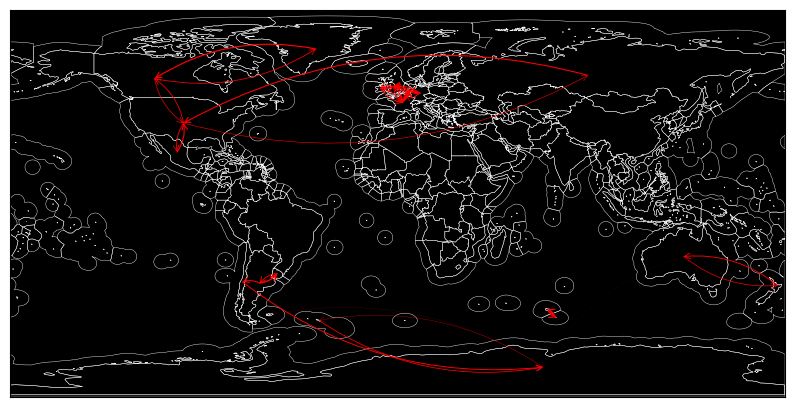

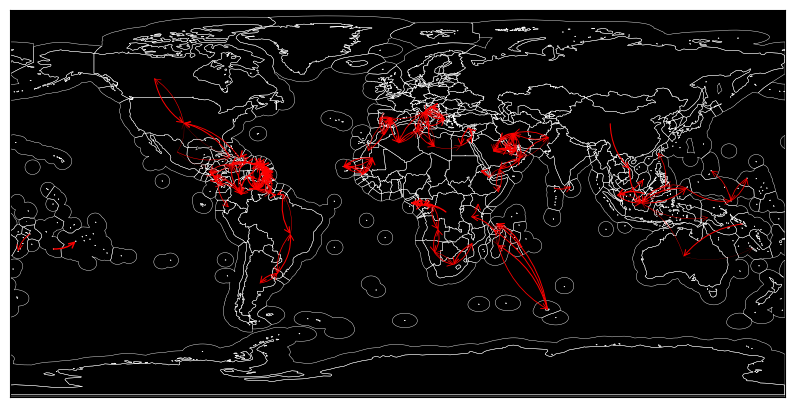

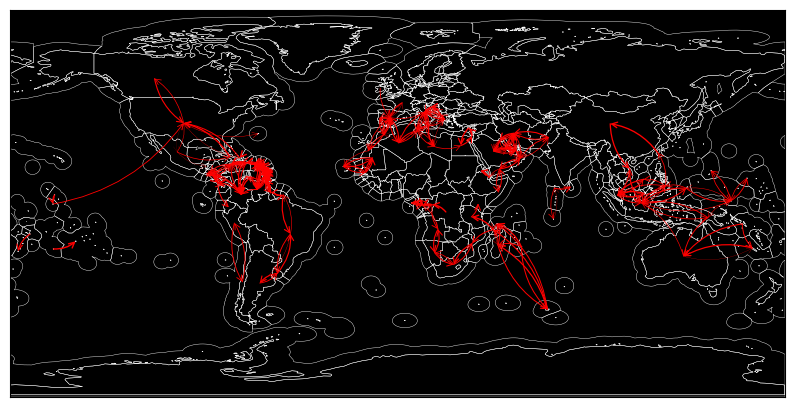

In [22]:
taxas = ["Cetaceans", "Fishes", "Seals", "Turtles"]
delays = ["1", "5"]

for taxa in taxas:
    print(f"Taxa: {taxa}")
    for delay in delays:
        print(f"Delay: {delay}")
        df = pd.read_csv(f"neteez/neteez_{taxa}_{delay}.csv")
        # normalize the weights to be between 1 and 10
        # df["Weight"] = df["Weight"] / df["Weight"].max() * 10
        G = nx.DiGraph()
        for i, row in df.iterrows():
            G.add_edge(row["Source"], row["Target"], weight=row["Weight"])
        remove_edges = long_edges(
            G, 
            rep_points_pos, 
            threshold=190
            )
        G.remove_edges_from(remove_edges)

        weights = [G[u][v]["weight"] for u, v in G.edges]

        weights = np.array(weights)
        weights = np.log(weights/weights.min())/np.log(1/weights.min())
        # plot the network, curving the edges to make it more readable
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_xlim(-180, 180)
        ax.set_ylim(-90, 90)
        ax.set_facecolor('black')       

        eezshape.set_geometry("continental_geometry", inplace=True)
        eezshape.plot(
            aspect=1,
            edgecolor="white",
            facecolor="none",
            linewidth=0.3,
            ax=ax
            )
        eezshape.set_geometry("marine_geometry", inplace=True)
        eezshape.plot(
            aspect=1,
            edgecolor="white",
            facecolor="none",
            linewidth=0.3,
            ax=ax
            )
        
        
        nx.draw_networkx_edges(G, 
            node_size=0,
            pos=rep_points_pos, 
            width = weights,
            edge_color="red",
            arrowstyle="->",
            connectionstyle='arc3,rad=0.2',
            ax=ax,
            min_source_margin=0,
            min_target_margin=0,)        
        ax.set_xticks([])
        ax.set_yticks([])



        fig.savefig(f"images/{taxa}_{delay}_days.png", dpi=300, bbox_inches="tight")
        fig.savefig(f"images/{taxa}_{delay}_days.pdf", dpi=300, bbox_inches="tight")